<a href="https://colab.research.google.com/github/koushika03/projects/blob/master/melanoma_skin_lesion_classification_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

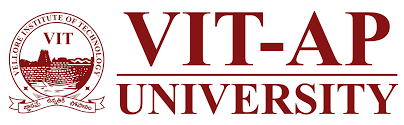

### Deep Learning Project-
### Melanoma skin lesion  classification using cnn


![A schematic illustration of the taxonom and ABCD-rule](https://drive.google.com/uc?id=1X7UF9sC5mZEi8syRqBaYP03vFtaefpM7)

#####the above image is a schematic illustration of the taxonomy for skin cancer and the ABCD rule.



#####Using deep learning and neural networks, a skin disease classifier is trained to distinguish between benign and malignant  skin diseases only from photographic images using the TensorFlow framework in Python. This can assist doctors in diagnosing tumors at an earlier stage. Equipped with deep neural networks and smartphone dermatoscopes, mobile devices can potentially extend the reach of dermatologists beyond the clinic. It could potentially reach more people and provide more informed diagnoses.



#####the necessary libraries

In [ ]:
pip install tensorflow tensorflow_hub matplotlib seaborn numpy pandas sklearn imblearn

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub#pre-trained models
import matplotlib.pyplot as plt#used for data visualization, including plotting graphs and charts.
import numpy as np#numerical counting in python
import pandas as pd#data manipulation and analysis.
import seaborn as sns#statistical data visualization
from tensorflow.keras.utils import get_file
from sklearn.metrics import roc_curve, auc, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score

import os
import glob
import zipfile
import random

#these lines below set random seeds for TensorFlow, NumPy, and Python's random module, respectively,
# this is done to ensure that the results are reproducible and consistent across multiple runs of the code.

tf.random.set_seed(7)
np.random.seed(7)
random.seed(7)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]

### Data preperation

In [ ]:
def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  # 5.1GB
  test_url  = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"
  for i, download_link in enumerate([valid_url, train_url, test_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=os.path.join(os.getcwd(), temp_file))
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(temp_file)


download_and_extract_dataset()

864538487/864538487 [==============================] - 16s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
5736557430/5736557430 [==============================] - 105s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
5528640507/5528640507 [==============================] - 236s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


In [ ]:
#
def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    # initializes an empty pandas DataFrame with columns "filepath" and "label" to store the image file paths and their labels.
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

# To generate CSV files for all data parts,
# with labels for nevus and seborrheic keratosis as 0 (benign) and melanoma as 1 (malignant),
# you need to run the generate_csv() function with the appropriate folder paths and label mappings
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

Reading data/train/nevus/*
Reading data/train/seborrheic_keratosis/*
Reading data/train/melanoma/*
Saving train.csv
Reading data/valid/nevus/*
Reading data/valid/seborrheic_keratosis/*
Reading data/valid/melanoma/*
Saving valid.csv
Reading data/test/nevus/*
Reading data/test/seborrheic_keratosis/*
Reading data/test/melanoma/*
Saving test.csv


In [ ]:
# loading data
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
# load CSV files as DataFrames
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
#These variables store the number of training and validation samples, respectively, which are determined by the length of the DataFrames.
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)  # 2000
print("Number of validation samples:", n_validation_samples)  # 150
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples: 2000
Number of validation samples: 150


In [ ]:
# preprocess data
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # image tensor to floats in the [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size of 299
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label

#(mapping function)
#This applies the process_path() function to each element in the dataset, which loads and preprocesses the image.
valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)  # (299, 299, 3)
    print("Label:", label.numpy())  # 0

Image shape: (299, 299, 3)
Label: 0


### preparing data set for training


In [ ]:
# training parameters
batch_size = 64
optimizer = "rmsprop"

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # prefetched to fetch batches in the background while the model is training, which improves training efficiency.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

#####cache(): The method is used to save the preprocessed dataset to a local cache file, which avoids recomputing the same transformations for each epoch during training. During the first run, the data will be preprocessed and saved in the cache file. In subsequent runs, the preprocessed data will be directly fetched from the cache file instead of recomputing it.

#####shuffle(): The method shuffles the dataset randomly, introducing randomness in the order of samples used during training. This prevents the model from learning patterns based on the original order of data.

#####repeat(): By using repeat(), the dataset will continue to generate samples for us in each epoch.

#####batch(): The method divides the dataset into smaller batches with 64 or 32 samples per training step. Using batches enables us to process multiple samples simultaneously, which improves training speed and GPU memory utilization.

#####prefetch(): This allows the dataset to fetch batches in the background while the model is training. Once a training step is done processing one batch, the dataset will have already fetched the next batch in advance, reducing training time and improving efficiency.





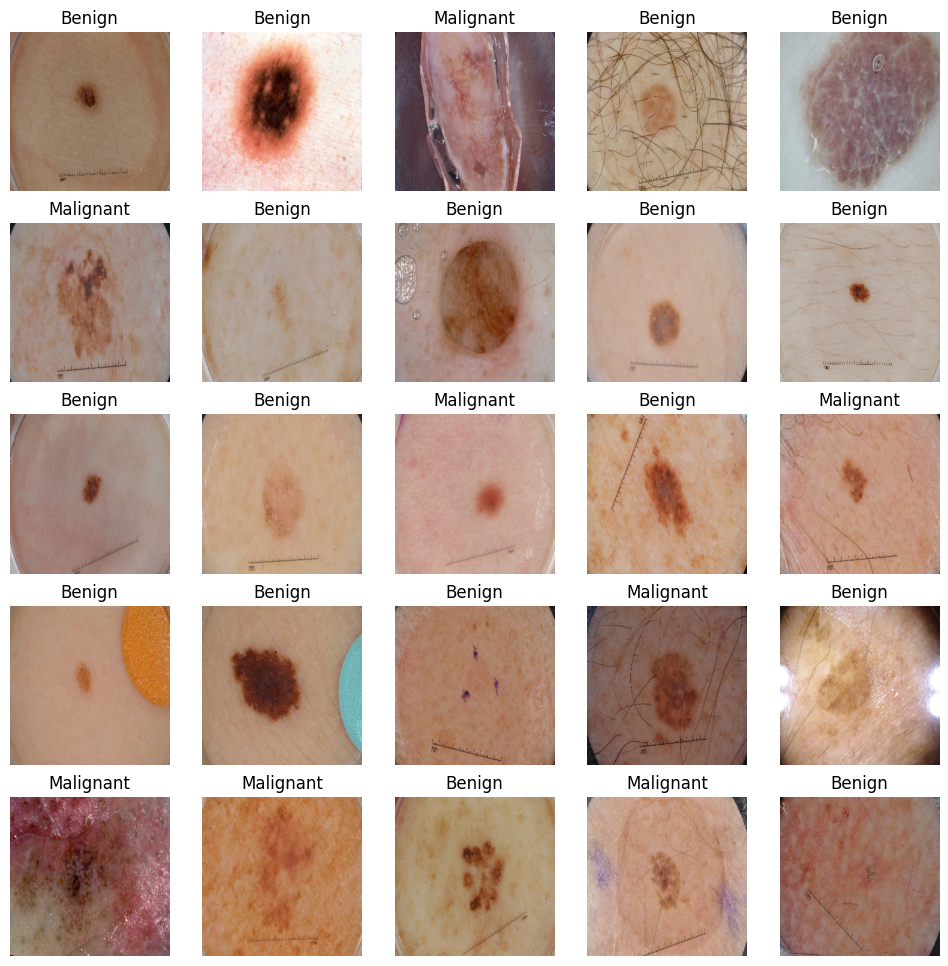

In [ ]:
#visualizing the images in a grid format
batch = next(iter(valid_ds))

def show_batch(batch):
  plt.figure(figsize=(12,12))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(batch[0][n])
      plt.title(class_names[batch[1][n].numpy()].title())
      plt.axis('off')

show_batch(batch)

#####The show_batch() function takes the batch as input and plots the images along with their corresponding labels in **a 5x5 grid**. For each image in the batch, it creates a **subplot** in the grid and displays the image using plt.imshow(). The title of each subplot is set to the class name of the image (either **"Benign" or "Malignant"**) using class_names[batch[1][n].numpy()]. The plt.axis('off') line removes the axis ticks and labels to provide a cleaner visualization.bold text


#####Earlier, we resized all images to (299, 299, 3), as this is the input size expected by the Inception V3 architecture. We utilize transfer learning with the TensorFlow Hub library to download and load the Inception V3 architecture along with its pretrained weights from ImageNet.



![Deep CNN layout](https://drive.google.com/uc?id=1QXm67SxxxYuvlSR2eE03O57pQf-NmsC2)

#####we first load the Inception V3 model using its TensorFlow Hub URL. We use a tf.keras.Sequential model, where the first layer is the Inception V3 model with its pre-trained weights (trainable=False to freeze the pre-trained layers). The input shape is set to (299, 299, 3) to match the expected input size of the Inception V3 model.

#####Next, we add a fully connected layer (tf.keras.layers.Dense) with two output units and a softmax activation function, as we are dealing with a binary classification problem (malignant vs. benign).

#####We then compile the model using 'adam' optimizer and 'sparse_categorical_crossentropy' as the loss function, as we are dealing with integer labels. Finally, we specify 'accuracy' as the metric to monitor during training.

####The model is now ready to be trained on the skin lesion dataset.







In [ ]:
# This line defines the URL of the Inception V3 model with pre-trained weights from TensorFlow Hub.
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    #it represents the number of output units generated by the Inception V3 feature vector.
    # for false (argument freezes the weights of the pre-trained model so that they are not updated during training)
    tf.keras.layers.Dense(1, activation="sigmoid")
    #output a value between 0 and 1, indicating the probability of the input image being malignant.
])

m.build([None, 299, 299, 3])#None represents a variable batch size
m.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


### To train the model
###### we will use the fit function from TensorFlow. This function will iteratively train the model on the training data and validate it on the validation data for a specified number of epochs
#####The TensorBoard callback is created to log training and validation metrics during the training process. It saves the logs in the specified log_dir, which is a subdirectory named after the model_name within the "logs" directory.
#####The ModelCheckpoint callback is used to save the model's weights whenever there is an improvement in validation loss. The saved model will have a filename based on the model_name and the validation loss value achieved during that epoch.
#####The training process will run for the specified number of epochs, and the model's performance on both the training and validation datasets will be recorded in the** history **object. You can then use this information to analyze the training progress and assess the model's performance.

In [ ]:
model_name = f"benign-vs-malignant_{batch_size}_{optimizer}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs", model_name))
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name + "_{val_loss:.3f}.h5", save_best_only=True, verbose=1)

history = m.fit(train_ds, validation_data=valid_ds,
                steps_per_epoch=n_training_samples // batch_size,
                validation_steps=n_validation_samples // batch_size, verbose=1, epochs=30,  # epochs=100
                callbacks=[tensorboard, modelcheckpoint])

Epoch 1/30
31/31 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8049 
Epoch 1: val_loss improved from inf to 0.54147, saving model to benign-vs-malignant_64_rmsprop_0.541.h5
31/31 [==============================] - 349s 11s/step - loss: 0.4119 - accuracy: 0.8049 - val_loss: 0.5415 - val_accuracy: 0.7578
Epoch 2/30
31/31 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8180 
Epoch 2: val_loss improved from 0.54147 to 0.47914, saving model to benign-vs-malignant_64_rmsprop_0.479.h5
31/31 [==============================] - 334s 11s/step - loss: 0.3952 - accuracy: 0.8180 - val_loss: 0.4791 - val_accuracy: 0.8047
Epoch 3/30
31/31 [==============================] - ETA: 0s - loss: 0.3778 - accuracy: 0.8201 
Epoch 3: val_loss did not improve from 0.47914
31/31 [==============================] - 338s 11s/step - loss: 0.3778 - accuracy: 0.8201 - val_loss: 0.4890 - val_accuracy: 0.7969
Epoch 4/30
31/31 [==============================] - ETA: 0s - l

##### the ModelCheckpoint callback is used to save the best weights achieved during training on each epoch
#####After training, the model's performance can be evaluated on a separate test dataset to assess its ability to generalize to new, unseen data.

### Model Evaluation
##### After training the model, it is essential to evaluate its performance to understand how well it generalizes to new, unseen data. Model evaluation helps assess the model's effectiveness and identifies any potential issues, such as overfitting or underfitting.
#####It's important to note that converting the entire testing set to numpy arrays and loading it into memory is practical only when the testing set is relatively small. If the testing set is large, batch-wise evaluation or other memory-efficient techniques should be considered to avoid memory limitations.

In [ ]:
# load testing set
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  return ds

test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of testing samples: 600


In [ ]:
# convert testing set to numpy array to fit in memory
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
#X_test is intended to store the image data, while y_test is intended to store the corresponding labels (0 for benign and 1 for malignant).
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  # print(img.shape, label.shape)
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [ ]:
# load the weights with the least loss
m.load_weights("/content/benign-vs-malignant_64_rmsprop_0.396.h5")

In [ ]:
print("Evaluating the model...")
loss, accuracy = m.evaluate(X_test, y_test, verbose=0)
#verbose=0 argument means that no progress bar or logging information will be shown during the evaluation process.
print("Loss:", loss, "  Accuracy:", accuracy)

Evaluating the model...
Loss: 0.4451175928115845   Accuracy: 0.7933333516120911


### Result
######The accuracy on the validation set is approximately 84%, and on the test set, it is about 80%. However, accuracy alone is not sufficient to evaluate the model's performance properly. The reason is that our dataset is highly imbalanced, so accuracy does not tell the whole story. In fact, a model that predicts every image as benign would achieve an accuracy of 80%, given that malignant samples make up around 20% of the total validation set.As a result, we need a better way to evaluate our model. In the upcoming cells, we will use the Seaborn and Matplotlib libraries to plot the confusion matrix, which will provide more insights into how well our model is performing.

In [ ]:
def get_predictions(threshold=None):
  """
  Returns predictions for binary classification given `threshold`
  For instance, if threshold is 0.3, then it'll output 1 (malignant) for that sample if
  the probability of 1 is 30% or more (instead of 50%)
  """
  y_pred = m.predict(X_test)
  if not threshold:
    threshold = 0.5  # threshold value that will improve our predictions.
  result = np.zeros((n_testing_samples,))
  for i in range(n_testing_samples):
    # test melanoma probability
    if y_pred[i][0] >= threshold:
      result[i] = 1
    # else, it's 0 (benign)
  return result

threshold = 0.23
# get predictions with 23% threshold
# which means if the model is 23% sure or more that is malignant,
# it's assigned as malignant, otherwise it's benign
y_pred = get_predictions(threshold)

19/19 [==============================] - 93s 5s/step


[[0.6252588  0.3747412 ]
 [0.27350427 0.72649573]]


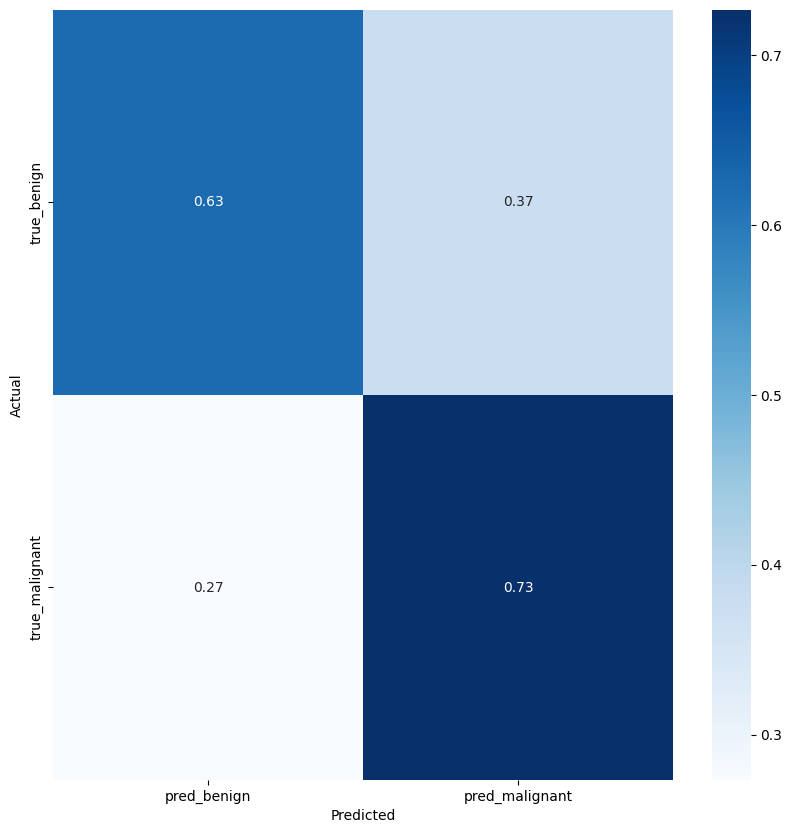

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
  cmn = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cmn.astype('float') / cmn.sum(axis=1)[:, np.newaxis]
  # print it
  print(cmn)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f',
              xticklabels=[f"pred_{c}" for c in class_names],
              yticklabels=[f"true_{c}" for c in class_names],
              cmap="Blues"
              )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  # plot the resulting confusion matrix
  plt.show()

plot_confusion_matrix(y_test, y_pred)


#####Sensitivity
#####So, our model achieves a sensitivity of approximately 0.72, given that the patient has the disease (lower-right cell in the confusion matrix), which is often referred to as sensitivity.

#####Sensitivity is a statistical measure commonly used in medicine.
 The higher the sensitivity, the better the model is at identifying positive cases accurately.

#####Specificity
#####The second metric is specificity, which you can read at the upper-left cell of the confusion matrix. We obtained approximately 63% specificity. Specificity is the probability of a negative test result given that the patient is healthy.
#####High specificity means that the test rarely produces positive results for healthy patients, while high sensitivity indicates that the model is reliable when the result is negative.

In [ ]:
sensitivity = sensitivity_score(y_test, y_pred)
specificity = specificity_score(y_test, y_pred)

print("Melanoma Sensitivity:", sensitivity)
print("Melanoma Specificity:", specificity)

Melanoma Sensitivity: 0.7264957264957265
Melanoma Specificity: 0.6252587991718427


#####The Receiver Operating Characteristic (ROC) is a graphical plot that shows the diagnostic ability of our binary classifier. It displays the true positive rate (sensitivity) on the Y-axis and the false positive rate on the X-axis. The ideal point we want to achieve is in the upper-left corner of the plot, representing high sensitivity and low false positive rate.

####Here is the code to plot the ROC curve using matplotlib:

ROC AUC: 0.676


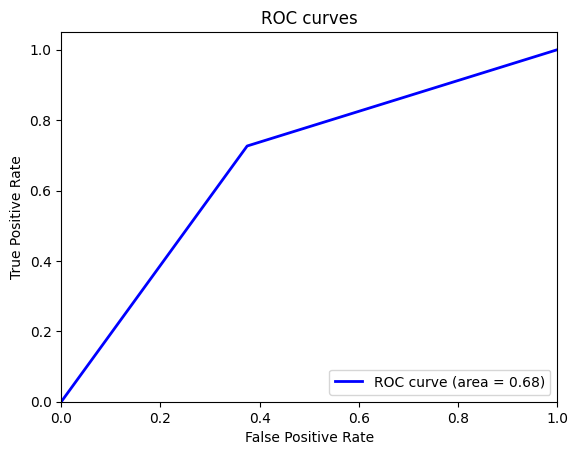

In [ ]:
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """
    # prepare for figure
    plt.figure()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    # obtain ROC AUC
    roc_auc = auc(fpr, tpr)
    # print score
    print(f"ROC AUC: {roc_auc:.3f}")
    # plot ROC curve
    plt.plot(fpr, tpr, color="blue", lw=2,
                label='ROC curve (area = {f:.2f})'.format(d=1, f=roc_auc))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_auc(y_test, y_pred)

![t-SNE visualization of the last hidden layer](https://drive.google.com/uc?id=1A9dyxRnsnnjVng__YDfCtxlYJHNsIu0n)

##### it reduces the number of unnecessary excisions of benign lesions, and it serves as a single network for both photographic and dermoscopic images. By breaking down the multiclass problem into binary, it reduces complexity. CNN does not require handcrafted features, is robust to photographic variations, and outperforms most dermatologists in terms of accuracy. The model can be further improved by adjusting hyperparameters